Total VNE :4

******************************************************

VNE-CDN :

Acceptance Ratio : 0.04
Total Revenue : 49530.0
Total Cost : 57183.0
Revenue/Cost : 0.8661665180210902

******************************************************



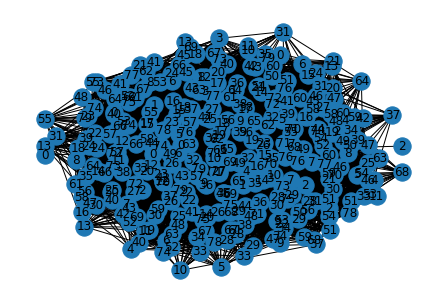

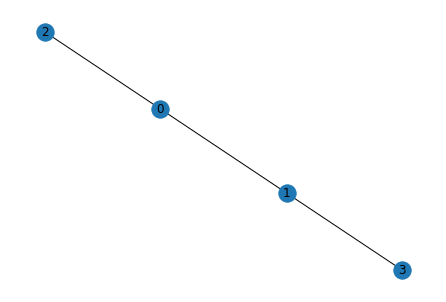

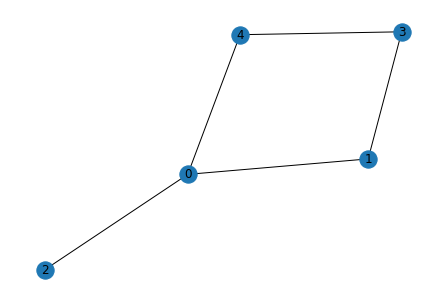

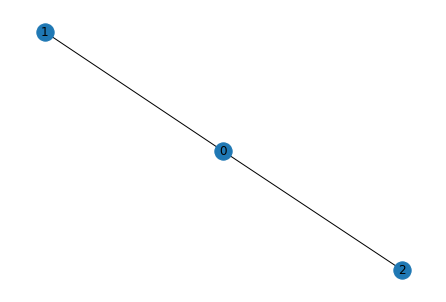

In [ ]:
import pickle
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import collections
import copy
import json, yaml



class Parameters:
    def __init__(
        self,
        lower_edge,
        upper_edge,
        lower_node,
        upper_node,
    ) -> None:
        self.lower_edge = lower_edge
        self.uppper_edge = upper_edge
        self.lower_node = lower_node
        self.upper_node = upper_node


class Graph:
    def __init__(self, nodes, edges, parameters) -> None:
        lower_edge = parameters.lower_edge
        upper_edge = parameters.uppper_edge
        lower_node = parameters.lower_node
        upper_node = parameters.upper_node
        self.nodes = nodes
        self.edges = list(edges)
        self.neighbours = dict()
        self.node_weights = dict() # CRB
        self.edge_weights = dict() # BandWidth
        self.parameters = parameters
        for a, b in edges:
            self.edge_weights[(a, b)] = int(np.random.uniform(lower_edge, upper_edge))
            self.edge_weights[(b, a)] = self.edge_weights[(a, b)]
        for i in range(self.nodes):
            self.node_weights[i] = int(np.random.uniform(lower_node, upper_node))
        for i in range(self.nodes):
            self.neighbours[i] = set()
            for a, b in self.edges:
                if int(a) == i:
                    self.neighbours[i].add(b)
    def BFS(self, src, dest, v, pred, dist, weight):
        queue = []
        visited = [False for i in range(v)]
        for i in range(v):
            dist[i] = 1000000
            pred[i] = -1
        visited[int(src)] = True
        dist[int(src)] = 0
        queue.append(src)
        while len(queue) != 0:
            u = queue[0]
            queue.pop(0)
            for i in self.neighbours[int(u)]:
                if visited[int(i)] == False and self.edge_weights[(u, i)] >= weight:
                # if visited[int(i)] == False and self.edge_weights[(str(u), i)] >= weight:
                    visited[int(i)] = True
                    dist[int(i)] = dist[int(u)] + 1
                    pred[int(i)] = u
                    queue.append(i)
                    if i == dest:
                        return True
        return False

    def findShortestPath(self, s, dest, weight):
        v = self.nodes
        pred = [0 for i in range(v)]
        dist = [0 for i in range(v)]
        ls = []
        if self.BFS(s, dest, v, pred, dist, weight) == False:
            return ls
        path = []
        crawl = dest
        crawl = dest
        path.append(crawl)
        while pred[int(crawl)] != -1:
            path.append(pred[int(crawl)])
            crawl = pred[int(crawl)]
        for i in range(len(path) - 1, -1, -1):
            ls.append(path[i])
        return ls

#create vne
def create_vne(min_nodes=2, max_nodes=8, no_requests=1, probability=0.4):
    random_node_list = [int(np.random.uniform(min_nodes, max_nodes)) for i in range(no_requests)]
    new_vne_req = []
    old_vne=[]
    for req in random_node_list:
        G = nx.erdos_renyi_graph(req, probability, directed=False)
        ng = nx.to_dict_of_lists(G)#For adcacency
        if not nx.is_connected(G):
          A=[k4 for k4 in range(req)]
          Groups_first_ele=[]
          while len(A)>0:
            B=[]
            B.append(A[0])
            T = nx.dfs_tree(G, source=A[0])
            for a,b in list(T.edges()):
              if B.count(a)==0:
                B.append(a)
              if B.count(b)==0:
                B.append(b)
            Groups_first_ele.append(B[0])
            A=list(set(A) - set(B))
          for k1 in range(len(Groups_first_ele)-1):
            ng[Groups_first_ele[k1]].append(Groups_first_ele[k1+1])
            ng[Groups_first_ele[k1+1]].append(Groups_first_ele[k1])
        old_vne.append(ng)
   
    vne = []
    #print("Total VNE persent :"+str(no_requests))
    for i in range(no_requests):
        edges = set()
        nodes = random_node_list[i]
        for j in range(nodes):
            for k in old_vne[i][j]:
                edges.add((str(j), str(k)))
        plt.figure(i)
        nx.draw(nx.Graph(edges),with_labels=True)
        
        vne.append(Graph(nodes, edges, Parameters(100, 500, 1000, 5000)) )  
    return vne


# if __name__ == "__main__":
#     my_vne=create_vne()
#     print("new VNE REQ is",my_vne[0].neighbours)

# my_vne[0].edge_weights

def revenue(vnr):
  # sum of bw requirements and compute requirements
  bwSum, crSum = 0, 0
  vnr_edge_bw = vnr.edge_weights
  vnr_crb = vnr.node_weights

  for edge in vnr_edge_bw:
    bwSum += 0.5*vnr_edge_bw[edge]

  for node in vnr_crb:
    crSum += vnr_crb[node]

  return bwSum + crSum

def get_srr(sng, node, hops):
  # return srr val
  l = 0.1
  cpu = sng.node_weights[node]
  bw_sum = 0

  for node_2 in sng.neighbours[node]:
    bw_sum += sng.edge_weights[(str(node), node_2)]
  
  try:
    srr_val = pow(l, hops[str(node)])*cpu*bw_sum
  except:
    print(hops)
  # srr_val = pow(l, hops[node]*cpu*bw_sum)
  return srr_val

class Vnr:
  def __init__(self, vnr, revenue, id):
    self.vnr = vnr
    self.revenue = revenue
    self.id = id

def generate_nc_map(vnr):
  G = nx.Graph()
  G.add_edges_from(vnr.edges)
  nc_map = nx.closeness_centrality(G)
  # print("cc map", nc_map)
  return nc_map

def generate_vrr_map(vnr):
  nc_map = generate_nc_map(vnr)
  vrr_map = dict()
  for node in vnr.node_weights:
    bw_sum = 0
    for node_2 in vnr.neighbours[node]:
      bw_sum += vnr.edge_weights[(str(node), node_2)]  

    vrr_val = nc_map[str(node)]*vnr.node_weights[node]*bw_sum
    vrr_map[node] = vrr_val

  return vrr_map

class Experiment:
  def __init__(self, sn_graph, no_vnrs=10):
    self.sn_graph = sn_graph
    self.org_sn_graph = copy.deepcopy(sn_graph)
    self.vnrs = create_vne(no_requests = no_vnrs)


  def SRR_VRR_Algo(self, no_vnrs = 10):
    accepted = 0
    total_revenue = 0
    cost = revenue(self.sn_graph)

    # generate an sn
    sn = self.sn_graph # contains node_weights, edge_weights & a map of neighbours
    
    # assume server to be 0 node
    server = 0

    # create hops map { str node: int hops}
    G = nx.Graph()
    G.add_edges_from(sn.edges)
    hops = nx.single_source_shortest_path_length(G, source = str(server))

    # queue for sn nodes 
    sn_queue = [int(key) for key in sn.node_weights]
    # sn_queue.sort(key=lambda x: srr_map[x])

    # map to store node mappings of each vnr
    vnr_to_sn_map = dict()

    # generate vnrs and add them to a queue after sorting by revenue
    # there will also be a copy of the vnrs in the vnr_list
    vnr_list = copy.copy(self.vnrs)
    for i in range(len(vnr_list)):
      vnr_list[i] = Vnr(vnr_list[i], revenue(vnr_list[i]), id = i)

    vnr_list.sort(key = lambda a: a.revenue, reverse = True)
    vnr_queue = collections.deque(vnr_list)

    # try to map nodes of each VNR
    while vnr_queue:
      # backup 
      sn_queue_backup = copy.deepcopy(sn_queue)
      sn_graph_backup = copy.deepcopy(sn)
      vnr_wrapper_obj = vnr_queue.popleft()
      vnr = vnr_wrapper_obj.vnr
      vnr_id = vnr_wrapper_obj.id
      
      '''**********************Node Mapping **********************'''

      # generate vrr map for all nodes of the vnr
      vrr_map = generate_vrr_map(vnr)    

      # get a list of virtual nodes for this vnr and sort them acc to vrr
      vn_list = [key for key in vnr.node_weights]
      vn_list.sort(key = lambda a: vrr_map[a])

      # map to store the mapping for this current vnr
      vn_to_sn_map = dict()

      # boolean flag to check if vnr was accepted
      isAccepted = True

      # now try to map the nodes and update srr map
      while vn_list:
        # sort sn_queue on the basis of srr
        sn_queue.sort(key=lambda x: get_srr(sn, x, hops))


        vn = vn_list.pop()
        sn_list = copy.copy(sn_queue)
        sn_id = sn_queue[-1]
        if sn_id == server:
          sn_id = sn_queue[-2]

        if (sn.node_weights[sn_id] >= vnr.node_weights[vn]):
          # if constraints are fulfilled map the virtual node to the
          # substrate node and update 
          sn.node_weights[sn_id] -= vnr.node_weights[vn]
          vn_to_sn_map[vn] = sn_id
        else:
          # virtual node can't be mapped. roll back changes to the substrate
          # network
          self.sn_graph = sn_graph_backup
          sn_queue = sn_queue_backup
          isAccepted = False
          # print(f"Warning: virtual network id: {vnr_id} couldn't be accepted because node mapping of {vn}th node failed")
          break

      # if it was accepted then add it's mappings to the all vnr mappings map
      if isAccepted:
        vnr_to_sn_map[vnr_id] = vn_to_sn_map
        accepted += 1

    # store the vnr mapping as an object attribute
    self.vnr_to_sn_map = vnr_to_sn_map


    '''**********************Link Mapping **********************'''
    vnr_to_se_map = dict()
    self.vnr_to_se_map = vnr_to_se_map

    vnr_queue = collections.deque(vnr_list)

    while vnr_queue:
      # backup sn
      sn_graph_backup = copy.deepcopy(self.sn_graph)
      sn = self.sn_graph

      # get vnr
      vnr_wrapper_obj = vnr_queue.popleft()
      vnr = vnr_wrapper_obj.vnr
      vnr_id = vnr_wrapper_obj.id

      # variable to check if path was found or not
      pathExists = True
    
      # iterate through edges and find paths between the substrate nodes they've been mapped to
      if vnr_id not in vnr_to_sn_map:
        continue

      vnr_node_map = vnr_to_sn_map[vnr_id]
      vnr_edge_map = dict()

      for edge in vnr.edges:
        node1, node2 = edge
        s, d = vnr_node_map[int(node1)], vnr_node_map[int(node2)]

        # handle the case where s and d have been mapped to the same node
        if s == d:
          vnr_to_se_map[edge] = [s]
          continue

        # otherwise find the shortest path and update accordingly
        # link requirements is checked by the function itself so no need to check
        path = sn.findShortestPath(str(s), str(d), vnr.edge_weights[edge])
        # path = sn.findPathFromSrcToDst(str(s), str(d), vnr.edge_weights[edge])
        if path:
          for i in range(len(path)-1):
            sn.edge_weights[(path[i], path[i+1])] -= vnr.edge_weights[edge]
            sn.edge_weights[(path[i+1], path[i])] -= vnr.edge_weights[edge]
          vnr_edge_map[edge] = path
        else:
          pathExists = False
          break

      if pathExists:
        vnr_to_se_map[vnr_id] = vnr_edge_map
        total_revenue += revenue(vnr)
      else:
        self.sn_graph = sn_graph_backup
        discarded_vnr = self.vnr_to_sn_map.pop(vnr_id)
        for node in discarded_vnr:
          self.sn_graph.node_weights[discarded_vnr[node]] += vnr.node_weights[node]

    cost = cost - revenue(self.sn_graph)
    return total_revenue, cost, accepted



def getDemoSubstrateGraph():
  nodes = 80
  para = Parameters(20000, 25000, 25000, 40000)
  G=create_vne(nodes,nodes,1,0.4)[0]
  #print(G.edges)
  demo_substrate = Graph(nodes, G.edges, para)
  nx.draw(nx.Graph(G.edges),with_labels=True)
  return demo_substrate

if __name__ == "__main__":
  
  sn = getDemoSubstrateGraph()
  snCopy = copy.deepcopy(sn)
  totalVNE=100
  print("Total VNE :{}".format(totalVNE))
  exp = Experiment(snCopy, totalVNE)


  line = "\n******************************************************\n"
  # srr experiment
  rev, cost, acc = exp.SRR_VRR_Algo()
  acc_ratio = acc/100

  print(line)
  print("VNE-CDN :")
  print("\nAcceptance Ratio : {}".format(acc_ratio))
  print("Total Revenue : {}".format(rev))
  print("Total Cost : {}".format(cost))
  print("Revenue/Cost : {}".format(rev/cost))

  print(line)


getDemoSubstrateGraph()